In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
from scipy.sparse import hstack
import unimib_snowit_project.utils as u

## Importation

In [2]:
# root directory and pkl folder
root_dir_path = u.get_root_dir()
df_in_dir = "data_loaded"
data_pkl_dir_path = root_dir_path.joinpath(df_in_dir)

# pickle filenames
pkl_files = [
    'reviews.pkl',
    'reviews_labelled.pkl'
]

# dynamic generation of paths
pkl_paths = {file_name.split('.')[0]: data_pkl_dir_path.joinpath(file_name) for file_name in pkl_files}

dfs = {}

# loop on files
for name, path in pkl_paths.items():
    dfs[name] = pd.read_pickle(path)
    print(f"{name} loaded: {dfs[name].shape[0]} rows, {dfs[name].shape[1]} columns")

# Now you can access to data through:
reviews_df = dfs['reviews'] 
labelled_reviews_df = dfs['reviews_labelled']

reviews loaded: 93429 rows, 3 columns
reviews_labelled loaded: 327522 rows, 3 columns


## Data Exploration

In [3]:
labelled_reviews_df.shape

(327522, 3)

In [4]:
labelled_reviews_df.isna().sum()
# no missing values

labelled_review.uid    0
text                   0
sentiment_label        0
dtype: int64

In [5]:
labelled_reviews_df['labelled_review.uid'].unique()
# as expected, I have exactly one review per uid

<StringArray>
[     '0',      '1',      '2',      '3',      '4',      '5',      '6',
      '7',      '8',      '9',
 ...
 '462734', '462735', '462736', '462737', '462738', '462739', '462740',
 '462741', '462742', '462743']
Length: 327522, dtype: string

In [6]:
labelled_reviews_df['text'].unique()
# as expected, each line is a different review

array(["I'm no bitters expert but I bought it as a gift for a friend.  I was surprised when I heard that this was anise flavored because neither of us are fans of licorice flavored things and I wish the description had mentioned that.  I might have choosen another brand that didn't have that flavor.",
       "these are probably great in the right drinks, but i dont like them at all in an old fashioned. i'll stick with angostura",
       "I sent these to my dad for his bday and he said they were really pretty good. He's hard to buy for so that says a lot :)",
       ...,
       'These stars are small, so you can give 10-15 of those in one training session.  I tried to train our dog with "Ceaser dog treats",  it just made our puppy hyper.  If you compare the ingredients, you will know why.  Little stars has just basic food ingredients without any preservatives and food coloring.  Sweet potato flavor also did not make my hand smell like dog food.',
       'These are the BEST treats for tr

sentiment_label
positive    209973
neutral      87368
negative     30181
Name: count, dtype: Int64


positive: 64.11%
neutral: 26.68%
negative: 9.21%


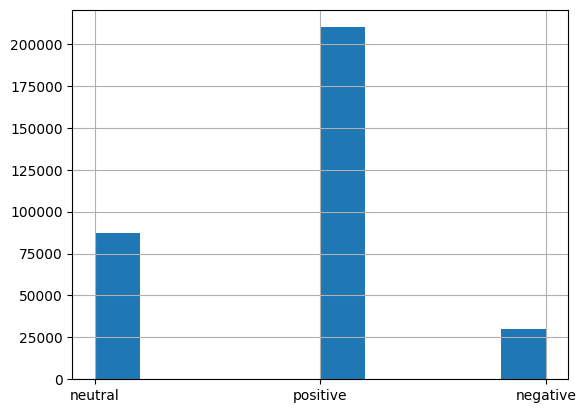

In [7]:
labelled_reviews_df['sentiment_label'].hist()
print(labelled_reviews_df['sentiment_label'].value_counts())
print("\n")
percentages = labelled_reviews_df['sentiment_label'].value_counts(normalize=True) * 100
for label, perc in percentages.items():
    print(f"{label}: {perc:.2f}%")
# we are dealing with an imbalanced dataset 

## Preprocessing

In [8]:
import re
import pandas as pd
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import PorterStemmer

stemmer = PorterStemmer() # stemmer object
stop_words = set(stopwords.words('english')) 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\davyt\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
def preprocess_text(text):
    # cleaning
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    text = text.lower()
    
    # tokenization
    tokens = text.split()
    
    # stopword removal
    tokens = [word for word in tokens if word not in stop_words]
    
    # stemming
    tokens = [stemmer.stem(word) for word in tokens]
    
    # return as str
    return ' '.join(tokens)

In [10]:
# apply it on data
labelled_reviews_df['processed_text'] = labelled_reviews_df['text'].apply(preprocess_text)

In [11]:
# example
pd.set_option('display.max_colwidth', None)
print(labelled_reviews_df[['text', 'processed_text']].head(1))
pd.reset_option('display.max_colwidth')

                                                                                                                                                                                                                                                                                                   text  \
0  I'm no bitters expert but I bought it as a gift for a friend.  I was surprised when I heard that this was anise flavored because neither of us are fans of licorice flavored things and I wish the description had mentioned that.  I might have choosen another brand that didn't have that flavor.   

                                                                                                                                          processed_text  
0  bitter expert bought gift friend surpris heard anis flavor neither us fan licoric flavor thing wish descript mention might choosen anoth brand flavor  


In [12]:
# labelling the sentiment
mapping = {'positive': 0, 'neutral': 1, 'negative': 2}
labelled_reviews_df['sentiment_label_target'] = labelled_reviews_df['sentiment_label'].map(mapping)


In [13]:
# example
labelled_reviews_df.head()

,labelled_review.uid,text,sentiment_label,processed_text,sentiment_label_target
0,0,I'm no bitters expert but I bought it as a gif...,neutral,bitter expert bought gift friend surpris heard...,1
1,1,"these are probably great in the right drinks, ...",neutral,probabl great right drink dont like old fashio...,1
2,2,I sent these to my dad for his bday and he sai...,positive,sent dad bday said realli pretti good hard buy...,0
3,3,I purchased these as a gift for family member ...,positive,purchas gift famili member love bbq pork warn ...,0
4,4,My wife bought me this sauce sampler for Chris...,neutral,wife bought sauc sampler christma know love bb...,1


## Train, Validation, Test split

In [14]:
# I can remove the id column since it's here useless
labelled_reviews_df = labelled_reviews_df.drop(['labelled_review.uid'], axis=1)
labelled_reviews_df.head()

,text,sentiment_label,processed_text,sentiment_label_target
0,I'm no bitters expert but I bought it as a gif...,neutral,bitter expert bought gift friend surpris heard...,1
1,"these are probably great in the right drinks, ...",neutral,probabl great right drink dont like old fashio...,1
2,I sent these to my dad for his bday and he sai...,positive,sent dad bday said realli pretti good hard buy...,0
3,I purchased these as a gift for family member ...,positive,purchas gift famili member love bbq pork warn ...,0
4,My wife bought me this sauce sampler for Chris...,neutral,wife bought sauc sampler christma know love bb...,1


In [15]:
from sklearn.model_selection import train_test_split

# first split: train (70%), rest (30%)
train_df, rest_df = train_test_split(
    labelled_reviews_df, 
    test_size=0.3, 
    stratify=labelled_reviews_df['sentiment_label'], 
    random_state=42
)

# second split: validation (15%), test (15%) 
val_df, test_df = train_test_split(
    rest_df, 
    test_size=0.5, 
    stratify=rest_df['sentiment_label'], 
    random_state=42
)

# check proportions
def label_distribution(df, set_name):
    counts = df['sentiment_label'].value_counts()
    percentages = df['sentiment_label'].value_counts(normalize=True) * 100
    summary = pd.DataFrame({
        'count': counts,
        'percentage': percentages
    })
    print(f"{set_name} label distribution:\n", summary, "\n")

label_distribution(train_df, "Train")
label_distribution(val_df, "Validation")
label_distribution(test_df, "Test")



Train label distribution:
                   count  percentage
sentiment_label                    
positive         146981   64.109655
neutral           61157   26.675245
negative          21127      9.2151 

Validation label distribution:
                  count  percentage
sentiment_label                   
positive         31496    64.11008
neutral          13105   26.675216
negative          4527    9.214704 

Test label distribution:
                  count  percentage
sentiment_label                   
positive         31496   64.108775
neutral          13106   26.676708
negative          4527    9.214517 



## Feature Engineering: TF-IDF

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [17]:
# target variable
x_train = train_df['processed_text']
y_train = train_df['sentiment_label_target']

x_val = val_df['processed_text']
y_val = val_df['sentiment_label_target']

x_test = test_df['processed_text']
y_test = test_df['sentiment_label_target']

In [18]:
#Tf-Idf 
vectorizer= TfidfVectorizer()

tf_x_train = vectorizer.fit_transform(x_train)
#fit(): the vectorizer analyzes x_train and it builds the vocabulary: the list of all the relevant words found.
#transform(): it transforms each x_train reviews in a row vector where each column represents a word of the vocabulary
#and each value is the TF-IDF weight of that word in that review.
#The result of tf_x_train is a sparse matrix (the majority of words don't belong to each review) of dimensions:
#( number_of_reviews, number_words_in_vocabulary): each line, basically, is a review

tf_x_validation = vectorizer.transform(x_val)

## Evaluating the best model on Validation Data

In [19]:
# Evaluation function

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(y_true, y_pred, dataset_name):
    results = {}
    results["dataset"] = dataset_name
    results["accuracy"] = accuracy_score(y_true, y_pred)
    
    # metrics for each class
    for cls in sorted(set(y_true)):
        results[f"precision: {cls}"] = precision_score(y_true, y_pred, labels=[cls], average="macro", zero_division=0)
        results[f"recall: {cls}"] = recall_score(y_true, y_pred, labels=[cls], average="macro", zero_division=0)
        results[f"f1: {cls}"] = f1_score(y_true, y_pred, labels=[cls], average="macro", zero_division=0)
    
    return results

#### Comparing: Logistic Regression, SVM, Naive Bayes

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, solver="saga", random_state=1312),
    "Linear SVM": LinearSVC(random_state=1312),
    "Naive Bayes": MultinomialNB()
}

# training different models
all_results = []

for model_name, model in models.items():
    print(f"\n--- Training {model_name} ---")

    # train
    model.fit(tf_x_train, y_train)
    
    # predictions
    y_train_pred = model.predict(tf_x_train)
    y_val_pred = model.predict(tf_x_validation)
    
    # evaluation
    train_results = evaluate_model(y_train, y_train_pred, "Train")
    val_results = evaluate_model(y_val, y_val_pred, "Validation")
    
    # model's name
    train_results["model"] = model_name
    val_results["model"] = model_name
    
    all_results.extend([train_results, val_results])
    
# final results
results_df = pd.DataFrame(all_results)
results_df = results_df.set_index(["model", "dataset"])

print(results_df)


--- Training Logistic Regression ---

--- Training Linear SVM ---

--- Training Naive Bayes ---
                                accuracy  precision: 0  recall: 0     f1: 0  \
model               dataset                                                   
Logistic Regression Train       0.795394      0.828220   0.927372  0.874996   
                    Validation  0.768299      0.813994   0.912306  0.860351   
Linear SVM          Train       0.818367      0.839464   0.940407  0.887073   
                    Validation  0.760971      0.805419   0.910751  0.854852   
Naive Bayes         Train       0.683057      0.681761   0.992550  0.808311   
                    Validation  0.671104      0.673437   0.990570  0.801784   

                                precision: 1  recall: 1     f1: 1  \
model               dataset                                         
Logistic Regression Train           0.695197   0.546920  0.612208   
                    Validation      0.638125   0.497596  0.5591

## Logistic Regression Fine Tuning

#### 1) Adding a feature through the Vader Lexicon

In [21]:
from nltk.sentiment import SentimentIntensityAnalyzer
# download, if needed
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\davyt\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [22]:
# from 'compound score' to label: 0,1,2

sia = SentimentIntensityAnalyzer()
def vader_predict(text):
    score = sia.polarity_scores(text)['compound']
    if score >= 0.05:
        return 2  #positive
    elif score <= -0.05:
        return 0  #negative
    else:
        return 1  #neutral

In [23]:
# new feature
from scipy.sparse import hstack

vader_preds_train = train_df['processed_text'].apply(vader_predict)
vader_preds_train = np.array(vader_preds_train).reshape(-1, 1)
x_train_vader = hstack([tf_x_train, vader_preds_train])

vader_preds_val = val_df['processed_text'].apply(vader_predict)
vader_preds_val = np.array(vader_preds_val).reshape(-1, 1)
x_val_vader = hstack([tf_x_validation, vader_preds_val])

In [24]:
all_results = []
model = LogisticRegression(max_iter=1000, solver="saga", random_state=1312)

# fit
model.fit(x_train_vader, y_train)
# predict
y_train_pred = model.predict(x_train_vader)
y_val_pred = model.predict(x_val_vader)
# evaluation
train_results = evaluate_model(y_train, y_train_pred, "Train")
val_results = evaluate_model(y_val, y_val_pred, "Validation")
# name
train_results["model"] = "Logistic Regression"
val_results["model"] = "Logistic Regression"

# final results
all_results.extend([train_results, val_results])
results_df = pd.DataFrame(all_results)
results_df = results_df.set_index(["model", "dataset"])
print(results_df)

                                accuracy  precision: 0  recall: 0     f1: 0  \
model               dataset                                                   
Logistic Regression Train       0.795185      0.828216   0.927310  0.874966   
                    Validation  0.768258      0.813657   0.912497  0.860247   

                                precision: 1  recall: 1     f1: 1  \
model               dataset                                         
Logistic Regression Train           0.694807   0.546250  0.611637   
                    Validation      0.638987   0.496757  0.558966   

                                precision: 2  recall: 2     f1: 2  
model               dataset                                        
Logistic Regression Train           0.758500   0.596583  0.667868  
                    Validation      0.689055   0.550696  0.612155  


In [25]:
# 1) results are basically the same with an improvement in class '2'

#### 2) Logistic Regression with Vader Lexicon & Balanced Weights & 5000 max iterations

In [26]:
all_results = []
model = LogisticRegression(max_iter=5000, solver="saga", class_weight="balanced", random_state=1312)

# fit
model.fit(x_train_vader, y_train)
# predict
y_train_pred = model.predict(x_train_vader)
y_val_pred = model.predict(x_val_vader)
# evaluation
train_results = evaluate_model(y_train, y_train_pred, "Train")
val_results = evaluate_model(y_val, y_val_pred, "Validation")
# name
train_results["model"] = "Logistic Regression"
val_results["model"] = "Logistic Regression"

# final results
all_results.extend([train_results, val_results])
results_df = pd.DataFrame(all_results)
results_df = results_df.set_index(["model", "dataset"])
print(results_df)

                                accuracy  precision: 0  recall: 0     f1: 0  \
model               dataset                                                   
Logistic Regression Train       0.757612      0.899106   0.786789  0.839206   
                    Validation  0.722154      0.880360   0.767939  0.820315   

                                precision: 1  recall: 1     f1: 1  \
model               dataset                                         
Logistic Regression Train           0.590596   0.650016  0.618883   
                    Validation      0.537870   0.592827  0.564013   

                                precision: 2  recall: 2     f1: 2  
model               dataset                                        
Logistic Regression Train           0.548913   0.866096  0.671955  
                    Validation      0.488488   0.777999  0.600153  


In [27]:
# 2) No improvement with respect to case 1

#### 3) Logistic Regression with Vader Lexicon & Oversampling 

In [28]:
from imblearn.over_sampling import RandomOverSampler

# create oversampler
oversampler = RandomOverSampler(sampling_strategy={1: 80000,
                                                   2: 40000},
                                 random_state=1312)

# oversampler applied
x_train_over, y_train_over = oversampler.fit_resample(x_train_vader, y_train)
print("Original distribution:\n", y_train.value_counts())
print("\nBalanced distribution:\n", y_train_over.value_counts())

# {'not minority', 'not majority', 'auto', 'minority', 'all'}

Original distribution:
 sentiment_label_target
0    146981
1     61157
2     21127
Name: count, dtype: int64

Balanced distribution:
 sentiment_label_target
0    146981
1     80000
2     40000
Name: count, dtype: int64


In [29]:
all_results = []
model = LogisticRegression(max_iter=1000, solver="saga", random_state=1312)

# fit
model.fit(x_train_over, y_train_over)
# predict
y_train_pred = model.predict(x_train_over)
y_val_pred = model.predict(x_val_vader)
# evaluation
train_results = evaluate_model(y_train_over, y_train_pred, "Train")
val_results = evaluate_model(y_val, y_val_pred, "Validation")
# name
train_results["model"] = "Logistic Regression"
val_results["model"] = "Logistic Regression"

# final results
all_results.extend([train_results, val_results])
results_df = pd.DataFrame(all_results)
results_df = results_df.set_index(["model", "dataset"])
print(results_df)

                                accuracy  precision: 0  recall: 0     f1: 0  \
model               dataset                                                   
Logistic Regression Train       0.781632      0.813825   0.896796  0.853298   
                    Validation  0.763556      0.835406   0.876810  0.855607   

                                precision: 1  recall: 1     f1: 1  \
model               dataset                                         
Logistic Regression Train           0.702148   0.598625  0.646267   
                    Validation      0.612477   0.534147  0.570637   

                                precision: 2  recall: 2     f1: 2  
model               dataset                                        
Logistic Regression Train           0.787259   0.724475  0.754563  
                    Validation      0.623869   0.639717  0.631694  


In [30]:
# 3) better results but, as expected, symptoms of overfitting

## Test Set

#### According to the previous section, considering the f1 metrics as the most representative, the best performance has been achieved by case n.1: the feature enrichment through Vader Lexicon.
#### This model is now used on test set.
#### Model with Oversampling wasn't chosen due to overfitting.

In [31]:
# preprocessing
tf_x_test = vectorizer.transform(x_test)
vader_preds_test = test_df['processed_text'].apply(vader_predict)
vader_preds_test = np.array(vader_preds_test).reshape(-1, 1)
x_test_vader = hstack([tf_x_test, vader_preds_test])

# modelling
all_results = []
model = LogisticRegression(max_iter=1000, solver="saga", random_state=1312)
# fit
model.fit(x_train_vader, y_train)
# predict
y_train_pred = model.predict(x_train_vader)
y_test_pred = model.predict(x_test_vader)
# evaluation
train_results = evaluate_model(y_train, y_train_pred, "Train")
test_results = evaluate_model(y_test, y_test_pred, "Test")
# name
train_results["model"] = "Logistic Regression"
test_results["model"] = "Logistic Regression"

# final results
all_results.extend([train_results, test_results])
results_df = pd.DataFrame(all_results)
results_df = results_df.set_index(["model", "dataset"])
print(results_df)

                             accuracy  precision: 0  recall: 0     f1: 0  \
model               dataset                                                
Logistic Regression Train    0.795185      0.828216   0.927310  0.874966   
                    Test     0.774756      0.816745   0.915831  0.863455   

                             precision: 1  recall: 1     f1: 1  precision: 2  \
model               dataset                                                    
Logistic Regression Train        0.694807   0.546250  0.611637      0.758500   
                    Test         0.651896   0.512971  0.574149      0.713061   

                             recall: 2     f1: 2  
model               dataset                       
Logistic Regression Train     0.596583  0.667868  
                    Test      0.551138  0.621729  


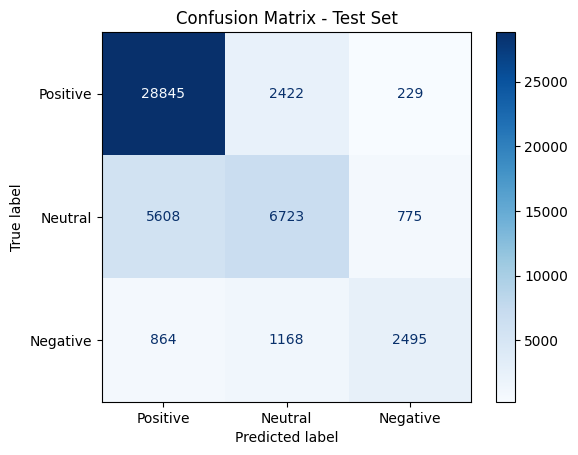

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# confusion matrix
cm = confusion_matrix(y_test, y_test_pred, labels=[0,1,2])
labels = ['Positive', 'Neutral', 'Negative']

# visualization
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix - Test Set")
plt.show()

# Best model trained on all the available Labelled data, applied on Unlabelled Data

## Import the two dataset

In [33]:
# root directory and pkl folder
root_dir_path = u.get_root_dir()
df_in_dir = "data_loaded"
data_pkl_dir_path = root_dir_path.joinpath(df_in_dir)

# pickle filenames
pkl_files = [
    'reviews.pkl',
    'reviews_labelled.pkl'
]

# dynamic generation of paths
pkl_paths = {file_name.split('.')[0]: data_pkl_dir_path.joinpath(file_name) for file_name in pkl_files}

dfs = {}

# loop on files
for name, path in pkl_paths.items():
    dfs[name] = pd.read_pickle(path)
    print(f"{name} loaded: {dfs[name].shape[0]} rows, {dfs[name].shape[1]} columns")

# Now you can access to data through:
reviews_df = dfs['reviews'] 
labelled_reviews_df = dfs['reviews_labelled']

reviews loaded: 93429 rows, 3 columns
reviews_labelled loaded: 327522 rows, 3 columns


In [34]:
reviews_df.head()

,review.uid,user.uid,text
0,1,tcdf7enqg9sxqq4ie4qh3xzjbt,I have bought several of the Vitality canned d...
1,2,kszpqbggktbzmtkkkejthwyucw,Product arrived labeled as Jumbo Salted Peanut...
2,3,l01hczdvthqra6hsxbovmqipdc,This is a confection that has been around a fe...
3,4,cmszp7l1j9pt53fvt178v3avxd,If you are looking for the secret ingredient i...
4,5,bhimnczlhxddegbdaytb7gbhx2,Great taffy at a great price. There was a wid...


In [35]:
reviews_df.shape

(93429, 3)

In [36]:
reviews_df['text'].unique()
# as expected, each line is a different review

array(['I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.',
       'Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".',
       'This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I highly recommend this yummy treat.  If you are familiar with the story of C.S. Lewis\' "The Lion, The Witch, and The Wardrobe" - this is the treat that seduces Edmund into selling out his Brother and Sisters to the Witch.',
    

## Preprocessing

In [37]:
# preprocess the text
labelled_reviews_df['processed_text'] = labelled_reviews_df['text'].apply(preprocess_text)
reviews_df['processed_text'] = reviews_df['text'].apply(preprocess_text)

In [38]:
# label the sentiment
mapping = {'positive': 0, 'neutral': 1, 'negative': 2}
labelled_reviews_df['sentiment_label_target'] = labelled_reviews_df['sentiment_label'].map(mapping)

In [39]:
# saving uid 
user_ids = reviews_df["user.uid"].copy()

## Train & Test split

In [40]:
# I can remove the id and the text columns since they are here useless
labelled_reviews_df = labelled_reviews_df.drop(['labelled_review.uid','text'], axis=1)
labelled_reviews_df.head()

,sentiment_label,processed_text,sentiment_label_target
0,neutral,bitter expert bought gift friend surpris heard...,1
1,neutral,probabl great right drink dont like old fashio...,1
2,positive,sent dad bday said realli pretti good hard buy...,0
3,positive,purchas gift famili member love bbq pork warn ...,0
4,neutral,wife bought sauc sampler christma know love bb...,1


In [41]:
reviews_df = reviews_df.drop(['review.uid','user.uid','text'], axis=1)
reviews_df.head()

,processed_text
0,bought sever vital can dog food product found ...
1,product arriv label jumbo salt peanut peanut a...
2,confect around centuri light pillowi citru gel...
3,look secret ingredi robitussin believ found go...
4,great taffi great price wide assort yummi taff...


In [42]:
train_df = labelled_reviews_df
test_df = reviews_df

## Feature Engineering: TF-IDF

In [43]:
# target variable
x_train = train_df['processed_text']
y_train = train_df['sentiment_label_target']

x_test = test_df['processed_text']

In [44]:
#Tf-Idf 
vectorizer= TfidfVectorizer()

tf_x_train = vectorizer.fit_transform(x_train)

tf_x_test = vectorizer.transform(x_test)

## Training & Testing

In [45]:
# from 'compound score' to label: 0,1,2

sia = SentimentIntensityAnalyzer()
def vader_predict(text):
    score = sia.polarity_scores(text)['compound']
    if score >= 0.05:
        return 2  #positive
    elif score <= -0.05:
        return 0  #negative
    else:
        return 1  #neutral

In [46]:
# new feature

vader_preds_train = train_df['processed_text'].apply(vader_predict)
vader_preds_train = np.array(vader_preds_train).reshape(-1, 1)
x_train_vader = hstack([tf_x_train, vader_preds_train])

vader_preds_test = test_df['processed_text'].apply(vader_predict)
vader_preds_test = np.array(vader_preds_test).reshape(-1, 1)
x_test_vader = hstack([tf_x_test, vader_preds_test])

In [47]:
model = LogisticRegression(max_iter=1000, solver="saga", random_state=1312)

# fit
model.fit(x_train_vader, y_train)

# predict
y_train_pred = model.predict(x_train_vader)
y_test_pred = model.predict(x_test_vader)

# evaluation
train_results = evaluate_model(y_train, y_train_pred, "Train")

# name
train_results["model"] = "Logistic Regression"

# final results
all_results.extend([train_results])
results_df = pd.DataFrame(all_results)
results_df = results_df.set_index(["model", "dataset"])
print(results_df)

                             accuracy  precision: 0  recall: 0     f1: 0  \
model               dataset                                                
Logistic Regression Train    0.795185      0.828216   0.927310  0.874966   
                    Test     0.774756      0.816745   0.915831  0.863455   
                    Train    0.793886      0.828565   0.925705  0.874445   

                             precision: 1  recall: 1     f1: 1  precision: 2  \
model               dataset                                                    
Logistic Regression Train        0.694807   0.546250  0.611637      0.758500   
                    Test         0.651896   0.512971  0.574149      0.713061   
                    Train        0.690932   0.544169  0.608831      0.750311   

                             recall: 2     f1: 2  
model               dataset                       
Logistic Regression Train     0.596583  0.667868  
                    Test      0.551138  0.621729  
              

### Saving Dataset

In [48]:
sentiment_predicted = pd.DataFrame({
    "user_ids": user_ids,
    "y_test_pred": y_test_pred
})

sentiment_predicted.head()

,user_ids,y_test_pred
0,tcdf7enqg9sxqq4ie4qh3xzjbt,1
1,kszpqbggktbzmtkkkejthwyucw,2
2,l01hczdvthqra6hsxbovmqipdc,0
3,cmszp7l1j9pt53fvt178v3avxd,0
4,bhimnczlhxddegbdaytb7gbhx2,0


In [49]:
# project directory
from pathlib import Path
project_dir = Path.cwd().parents[0]
project_dir

WindowsPath('c:/Users/davyt/Desktop/Bicocca/Marketing Analytics/unimib_snowit_project')

In [50]:
# 'models' folder
models_dir = project_dir / "models"
models_dir.mkdir(parents=True, exist_ok=True) 
models_dir

WindowsPath('c:/Users/davyt/Desktop/Bicocca/Marketing Analytics/unimib_snowit_project/models')

In [51]:
# saving
sentiment_predicted.to_csv(models_dir / "predicted_sentiment.csv", index=False)